# 0.0 IMPORTS

In [117]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import html.parser
import random
import warnings
warnings.filterwarnings( 'ignore' )


from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
import xgboost as xgb
from boruta                import BorutaPy
from IPython.core.display  import HTML
from IPython.core.display  import Image
from tabulate              import tabulate




# 0.1 Helper functions

In [2]:
def cramer_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher. 
        """     
    
    cm = pd.crosstab(x, y).values  #.as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcoor = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n)/ (min(kcorr-1,  rcoor-1)))



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
jupyter_settings()



def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )


def cross_validation( x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    mape_list = []
    rmse_list = [] 
    for k in reversed( range(1, kfold+1 ) ):
        if verbose:
            print(' \nKFold Number: {}'.format( k ))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filterind dataset
        training = x_training[ x_training['date'] < validation_start_date ] 
        validation = x_training[( x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date ) ]  

        # training and validation  dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation= validation['sales']

        # model
        m = model.fit(xtraining, ytraining) 

        # prediction
        y_hat= m.predict(xvalidation)


        # performance
        m_result =ml_error( model_name, np.expm1(yvalidation), np.expm1(y_hat) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name, 
                  'MAE Cross Validation': np.round(np.mean( mae_list ), 2).astype(str) + ' +/- ' + np.round(np.std( mae_list), 2 ).astype(str),
                  "MAPE Cross Validation ": np.round(np.mean( mape_list ), 2).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                  "RMSE Cross Validation ": np.round(np.mean( rmse_list ), 2).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0])



Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw =pd.merge(df_sales_raw, df_store_raw , how ='left', on="Store")

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
699779,345,6,2013-10-12,3332,343,1,0,0,0,a,a,120.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRIÇÃO DE DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [9]:
print(' Number of Rows: {}'.format(df1.shape[0]))
print(' Number of Columns: {}'.format(df1.shape[1]))

 Number of Rows: 1017209
 Number of Columns: 18


## 1.3 Data Types  

In [10]:
# convert column "date" to datetime
df1['date'] = pd.to_datetime(df1['date']) 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5  Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)                         

#promo2_since_week     
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)                         

#promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)               

#promo_interval        

month_map ={1: 'Jan', 2 :'Fev', 3: 'Mar', 4: "Apr", 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep',10: "Oct", 11: 'Nov', 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5).T

,164889,45882,815979,636580,1001216
store,985,168,585,701,732
day_of_week,5,6,7,7,2
date,2015-03-06 00:00:00,2015-06-20 00:00:00,2013-06-30 00:00:00,2013-12-08 00:00:00,2013-01-15 00:00:00
sales,8796,3945,0,0,3459
customers,811,369,0,0,446
open,1,1,0,0,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,d,d,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types 

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7  Descriptive Statistical

### 1.7.1 Numerical Attributes

In [19]:

num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32',])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'int32','datetime64[ns]'])

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion -std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


# contatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

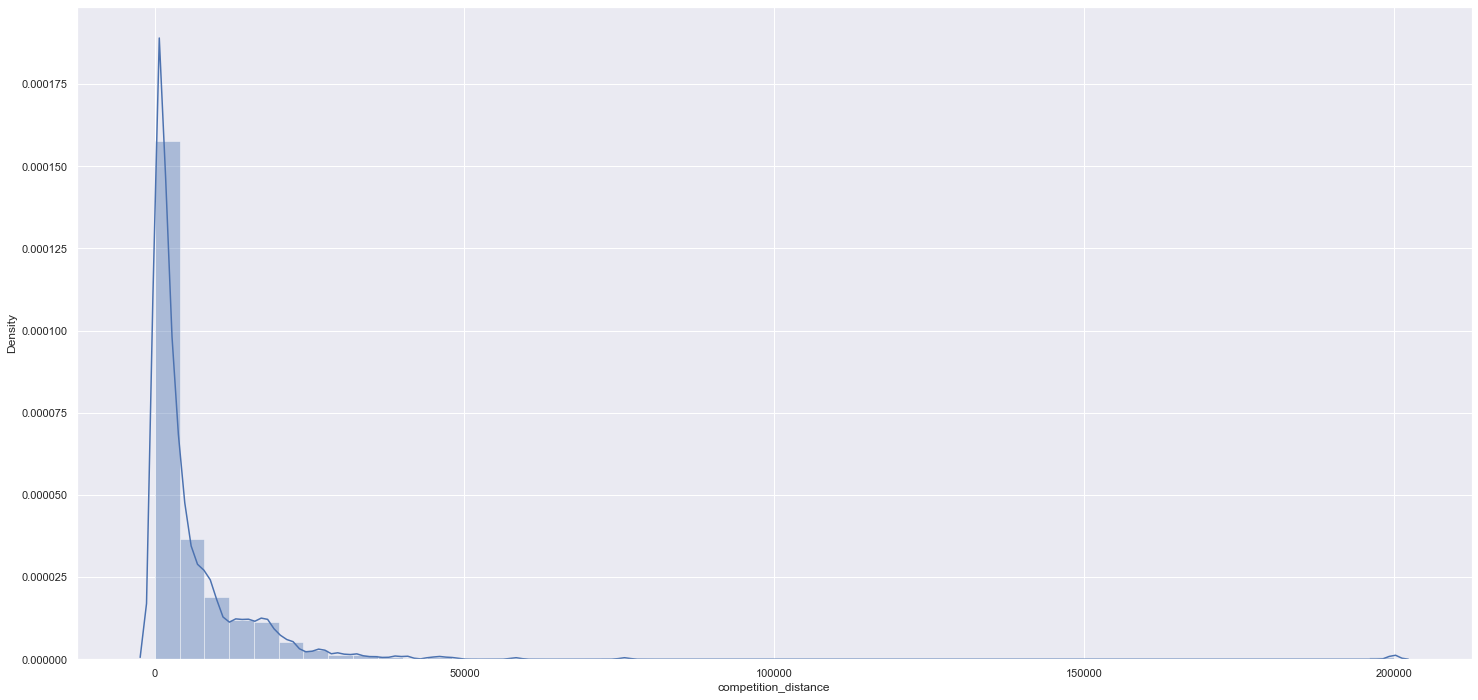

In [22]:
sns.distplot(df1['competition_distance'])

### 1.7.2  Categorial Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

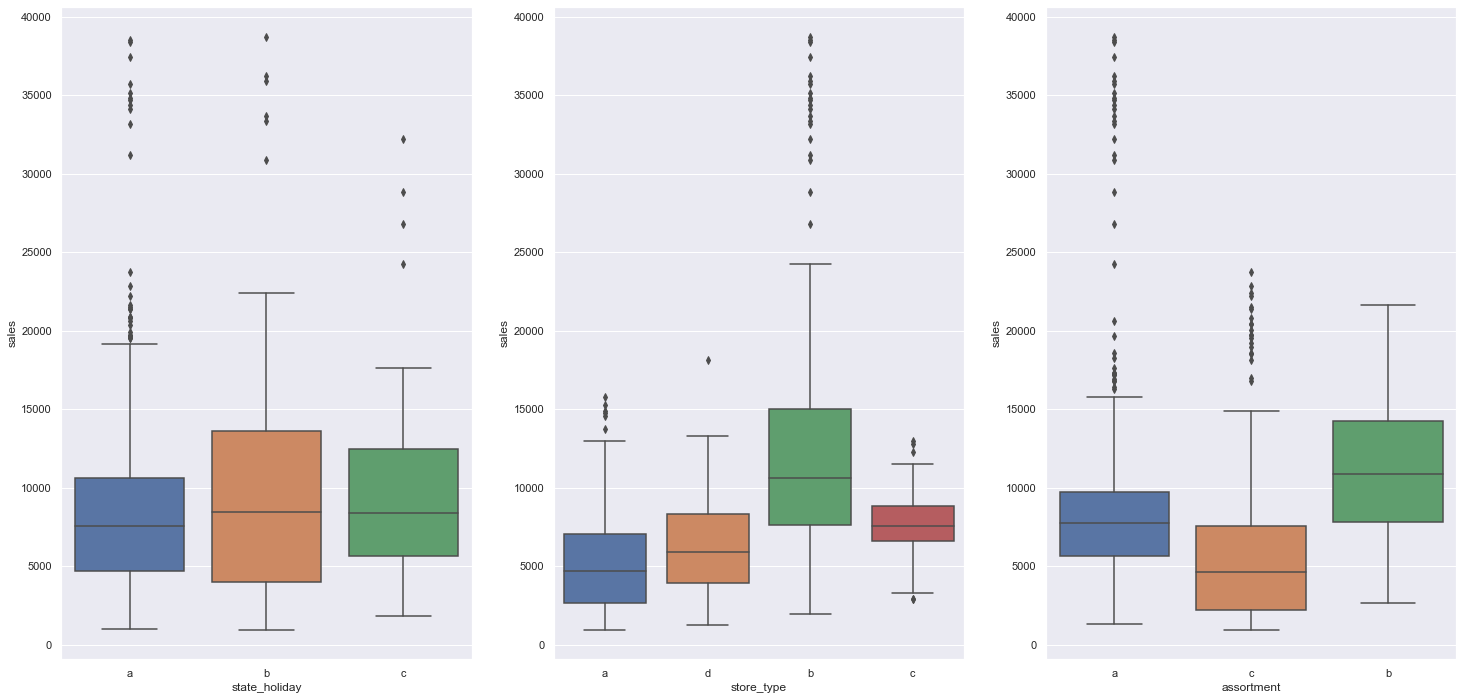

In [24]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']> 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y= 'sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y= 'sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y= 'sales', data=aux1)

## 2.0 FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

### 2.1 Hypothesis Mind Map 

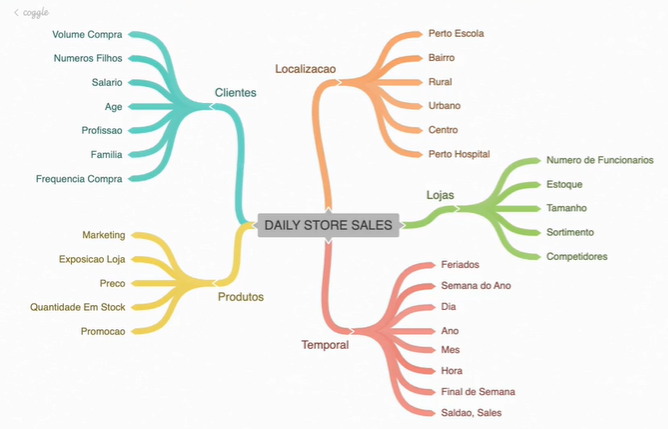

In [26]:
Image('img/MindMapHypothesis.png') # coogle.it

### 2.2 Creation of Hypotheses


#### 2.2.1 Store's Hypotheses

**1.**  Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais. 

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais



#### 2.2.3 Product's Hypotheses

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Loja com maior exposição dos produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas como promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas como promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


#### 2.2.2 Time's Hypotheses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10  de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.3 Final list of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais. 

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas como promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10  de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


### 2.4 Feature Engineering  


In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30 ).apply( lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+ '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7 ) )

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')



In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

In [29]:
df3 = df2.copy()

### 3.1 Row filtering

In [30]:
#adding business restrictions.
df3 = df3[(df3['open'] != 0)  &  (df3['sales'] > 0)]

### 3.2 Column selection

In [31]:
# adding business restrictions.
cols_drop =['customers','open','promo_interval','month_map']
df3.drop(cols_drop, axis =1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [32]:
df4 = df3.copy()

 ### 4.1 Univariate Analysis

 #### 4.1.2 Response Variable

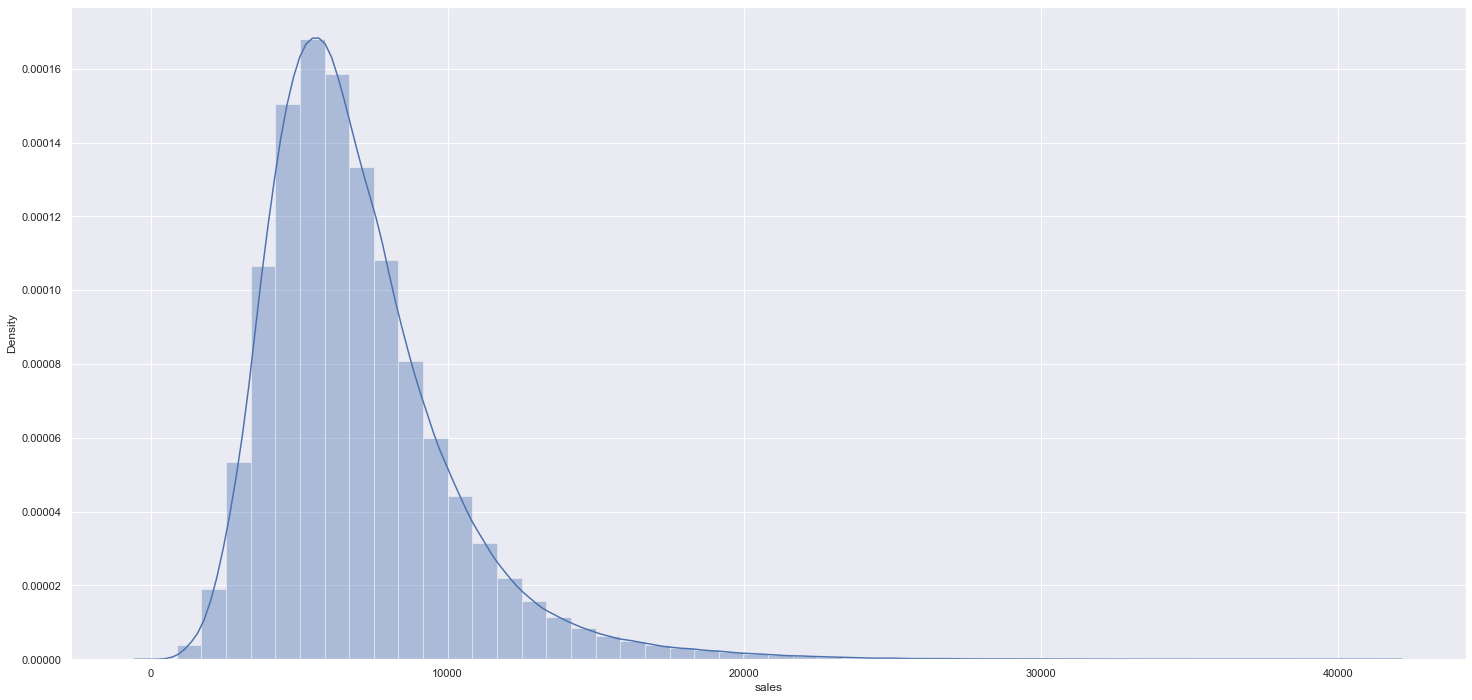

In [33]:
sns.distplot(df4['sales']);

 #### 4.1.2 Numerical Variable

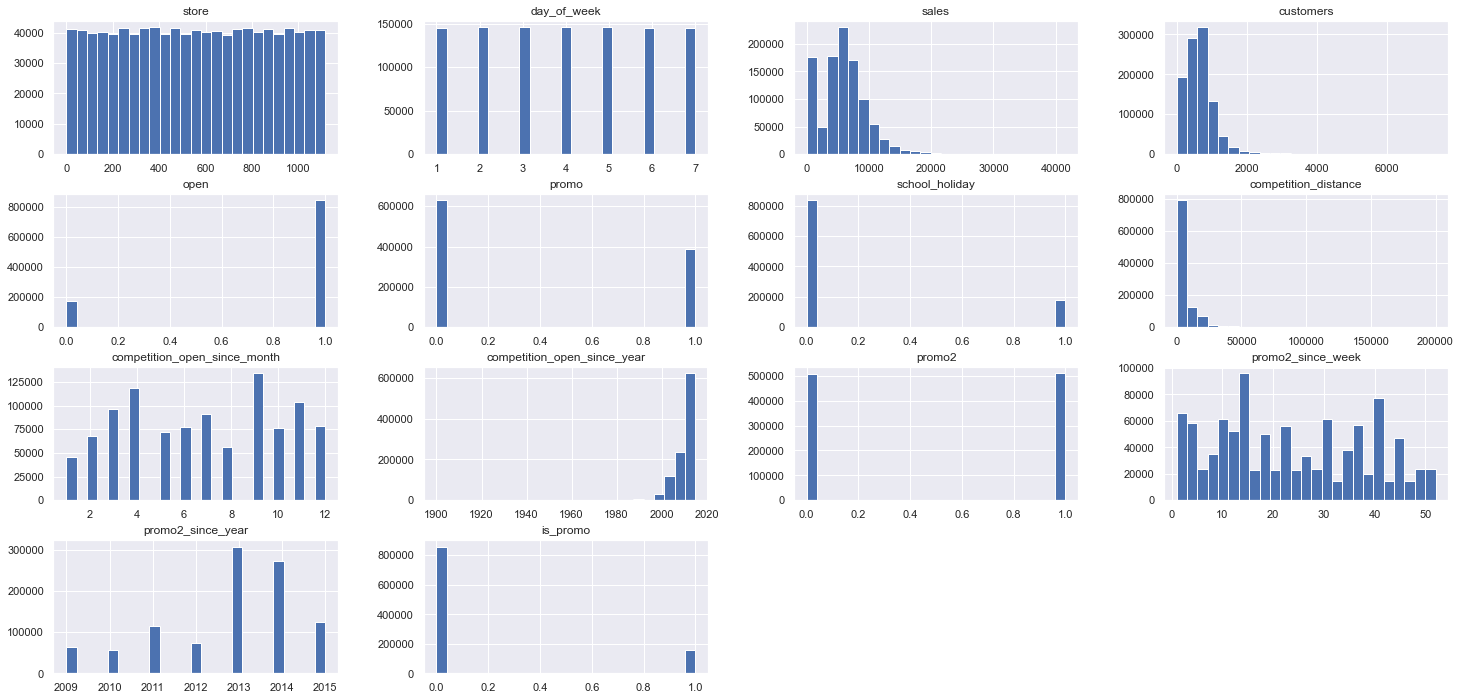

In [34]:
num_attributes.hist(bins=25);

## Some Conclusions referring to the Charts above.


**1.** **Compettion Distance** = We have a greater concentration among closest competitors.

**2.** **Is Promo** = we have a lot more sales when we don't have a promotion, this factor should be further investigated to understand if there are any anomalies in the data or in the business scenario.

**3.** **Sales** = The highest concentration of sales is between 0 and 1200 approximately, and the peak of sales is located at approximately 850.

**4.** **Customers** = I have more sales when customers reach 30,000, and I have less sales when customers are closer to 0 (zero).

**5.** **Compettion Since Month** = the peaks between competitors are in April, September and November and the minimum is in January and August.

**6.** **School Holiday** = we have less sales on School Holiday than on non-holidays. 




 #### 4.1.2 Categorical  Variable

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

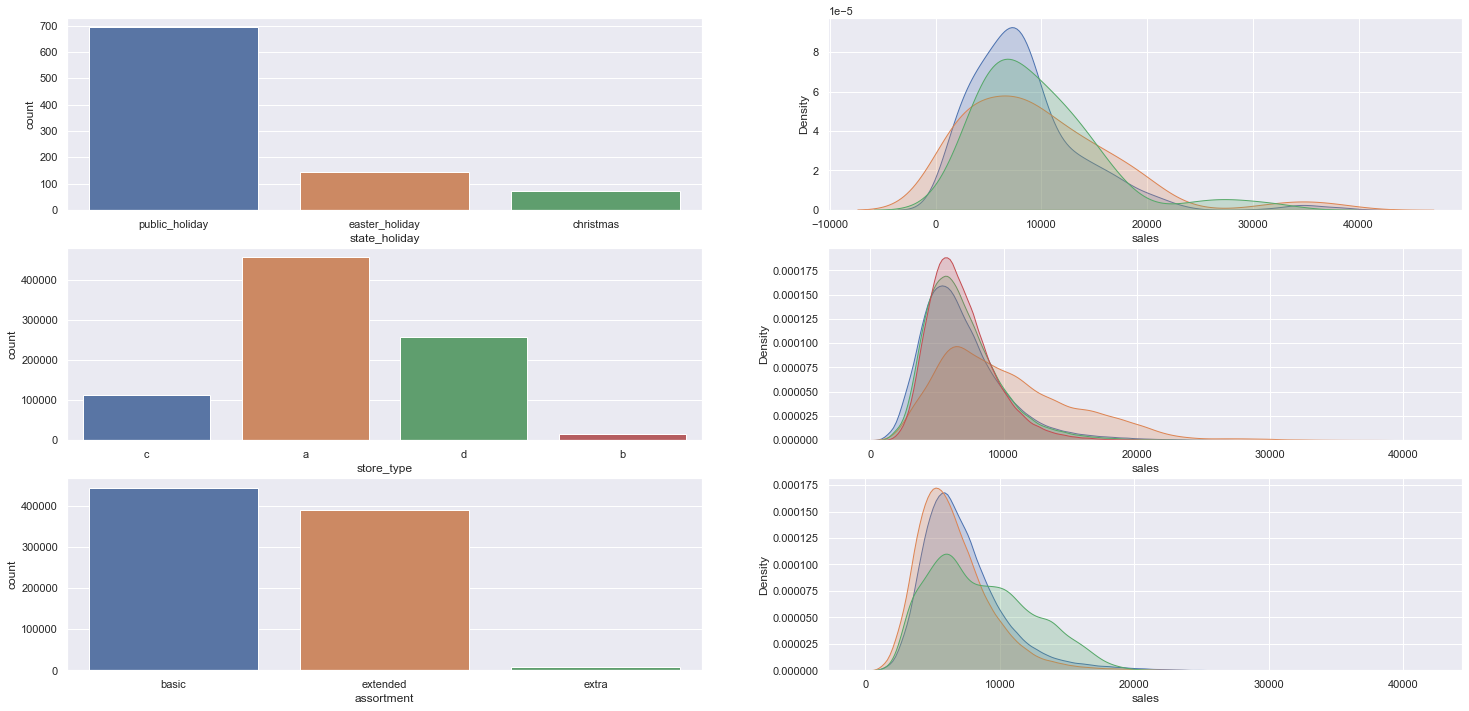

In [37]:
# state_holiday'
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day' ]
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);



 ### 4.1 Bivariate Analysis



### H1 Stores with larger assortments should sell more

**False Hypothesis** = Stores with GREATER ASSORTMENT SELL LESS.

**Basic and Extented** behave very similarly and this is where most of the sales are concentrated.

**Extra** has a very different consumption **Basic** and **Extented** and represents a small amount of sales in relation to the others

<AxesSubplot:xlabel='year_week'>

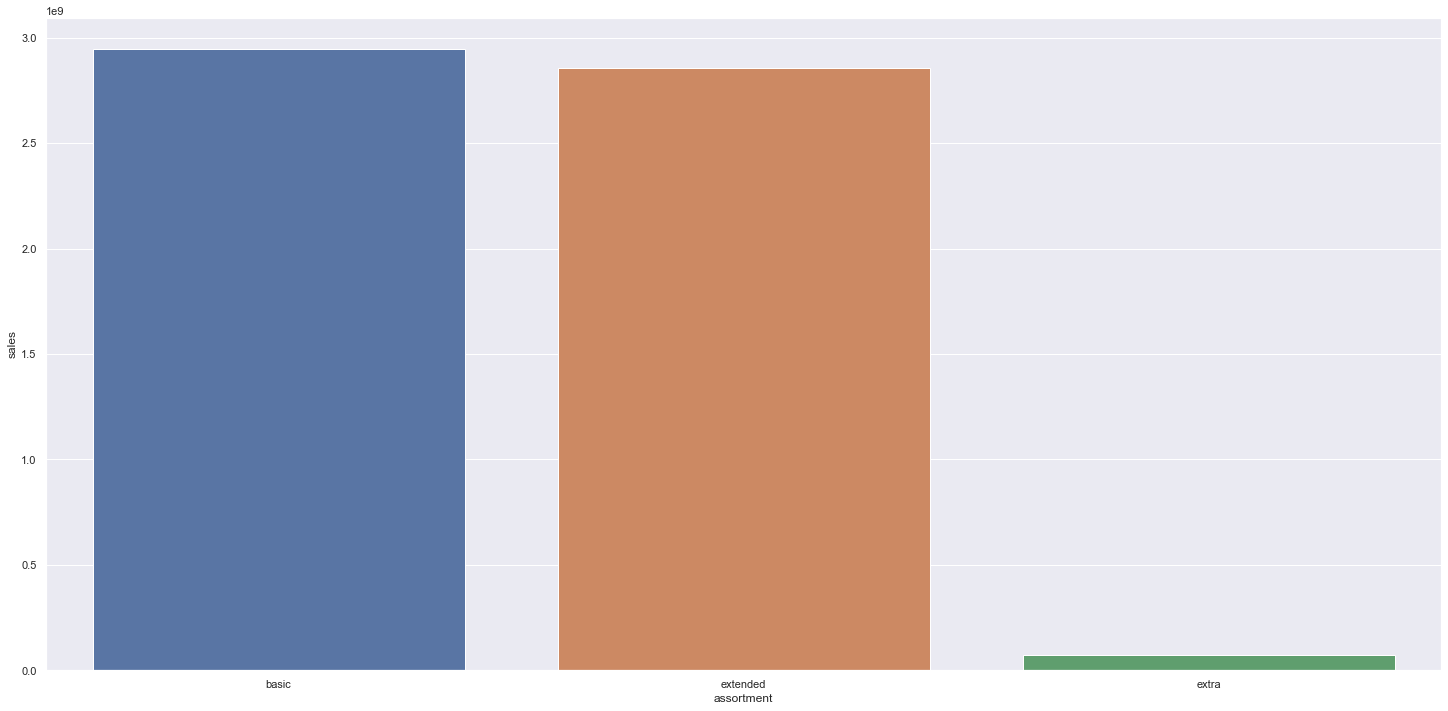

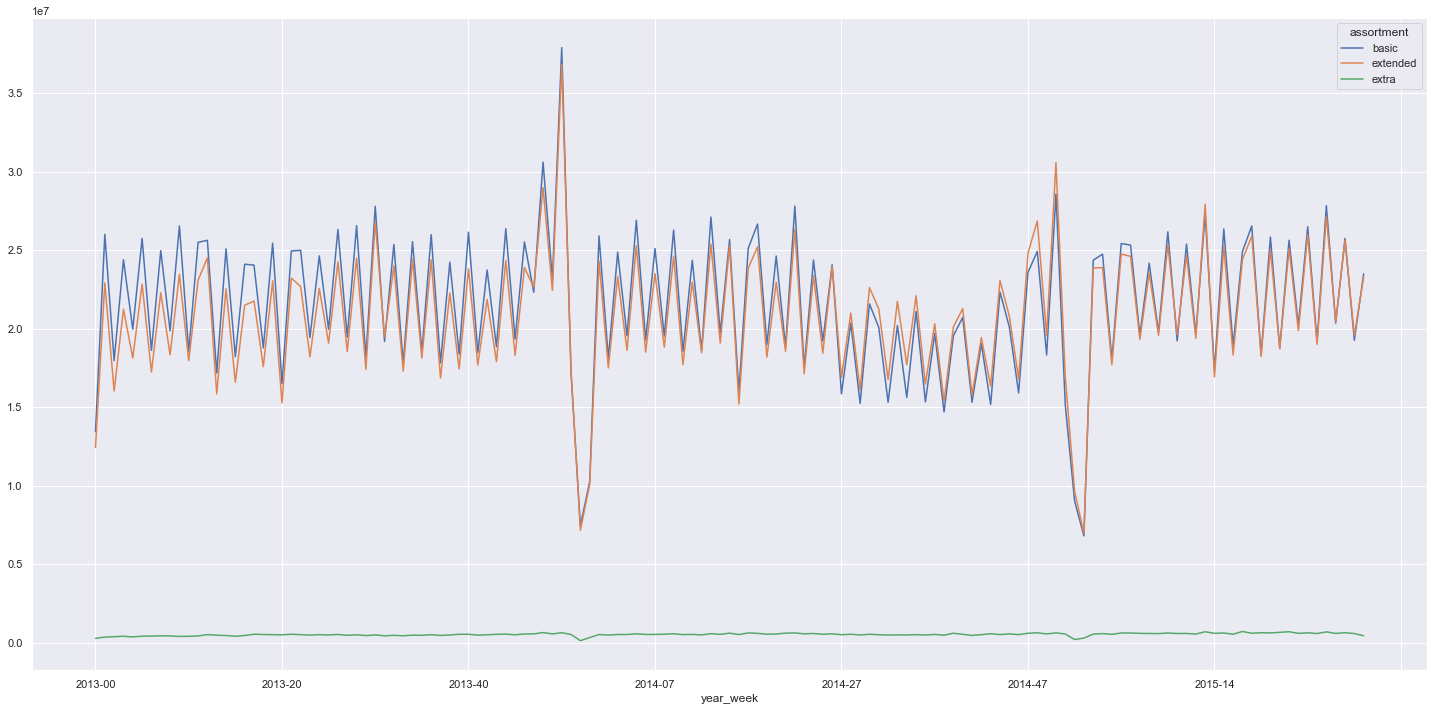

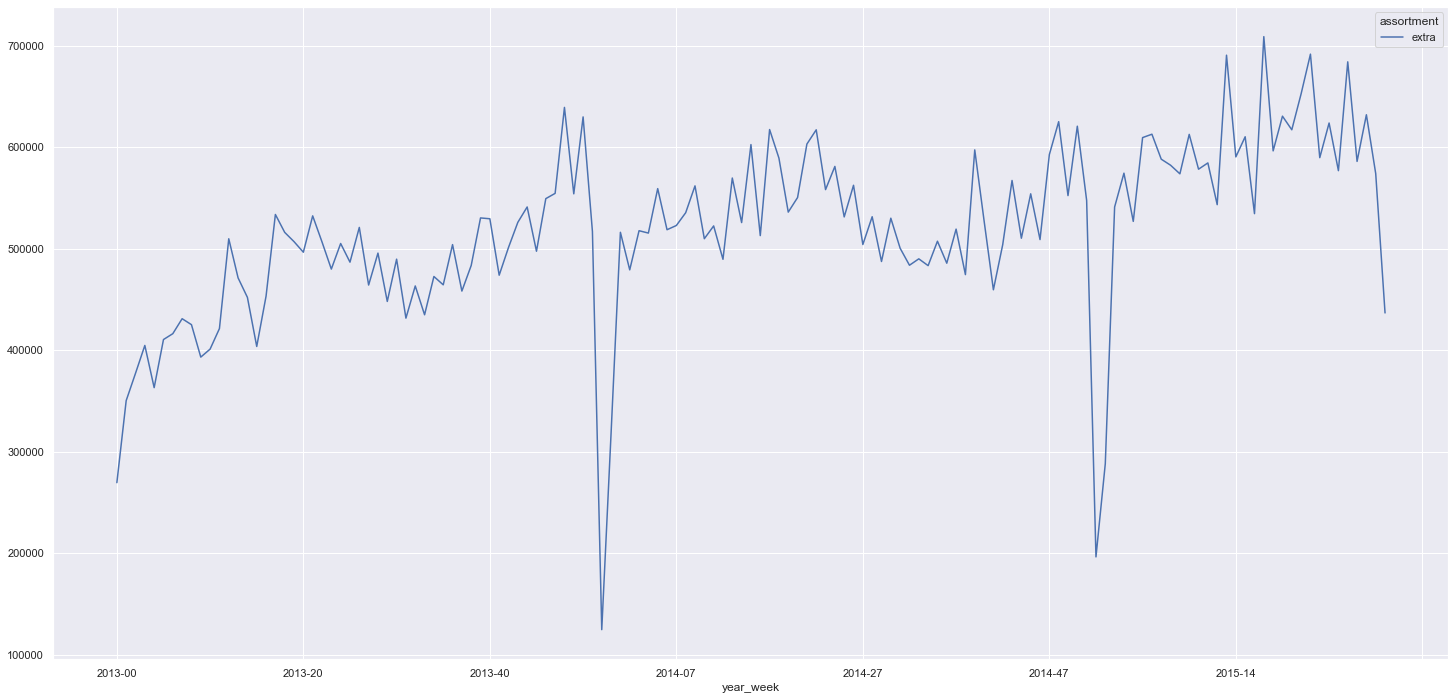

In [38]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y ='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()


### H2 Stores with closer competitors should sell less.
**False Hypothesis** = Stores with closest competitors sell more.

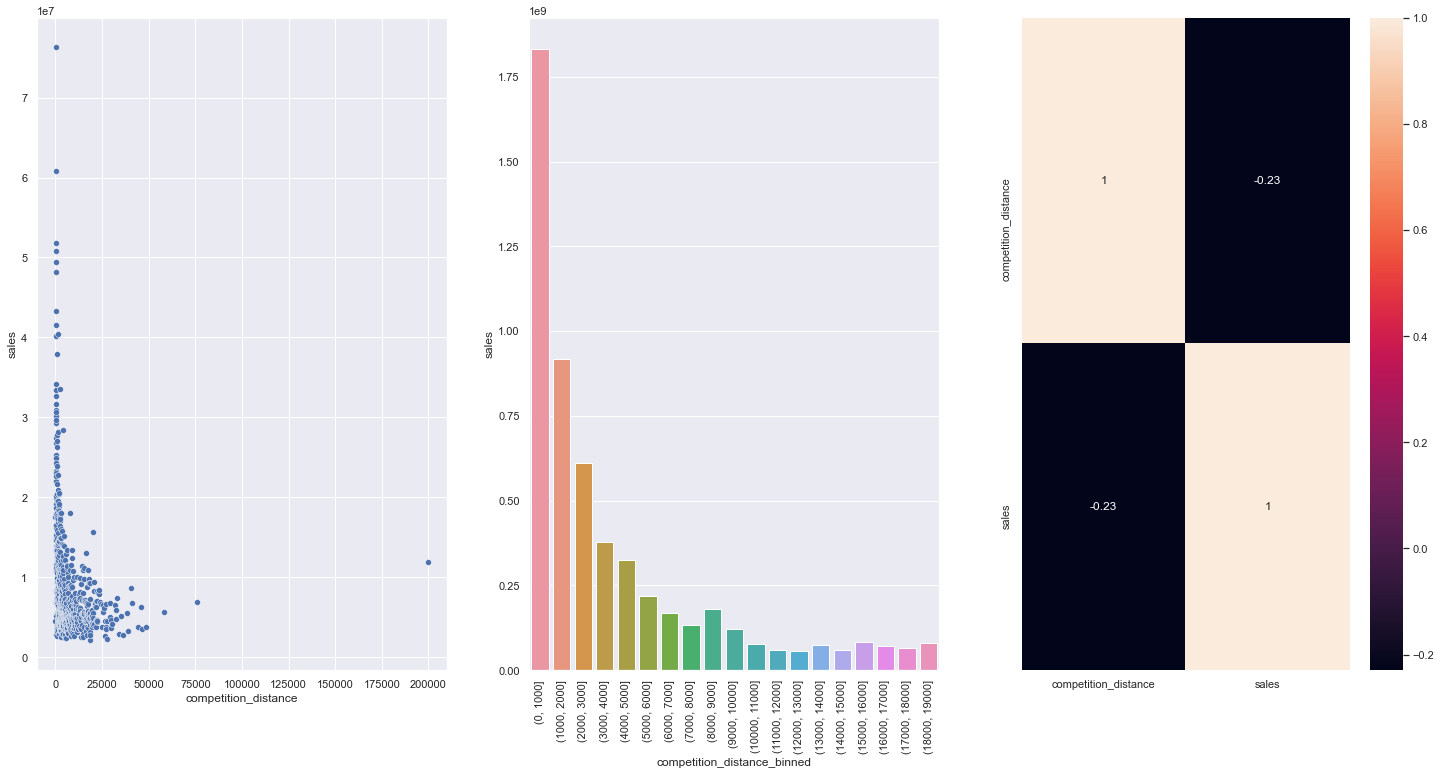

In [39]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data= aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 =aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H3 Stores with longer buyers should sell more.
**False Hypothesis** = Stores with longer competitors sell less.

**The more recent the competition, the bigger the sale.** (while the nearest to the highest is the number of sales) 

<AxesSubplot:>

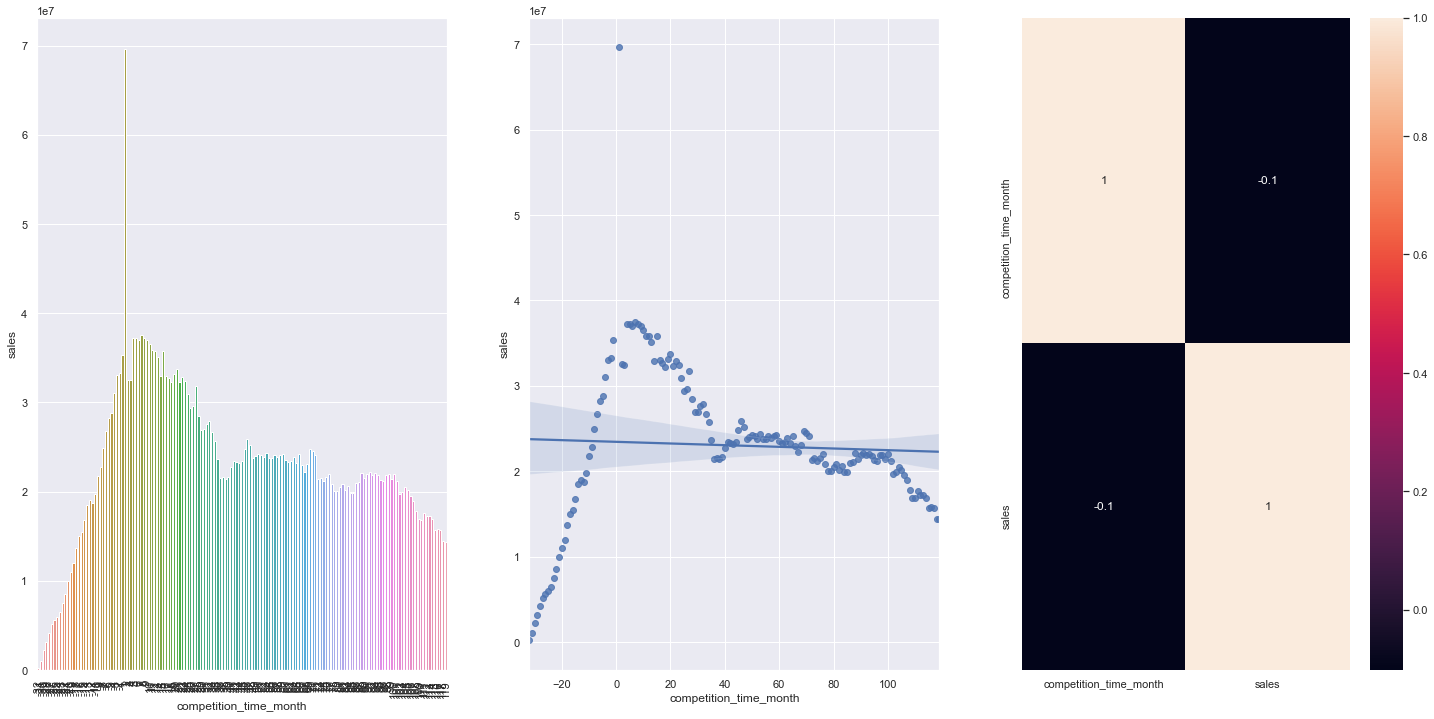

In [40]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)          

### H4 Stores with active promotions for longer should sell more.
**False Hypothesis** = Stores with active promotions for a longer time sell less, after a certain period of promotion.

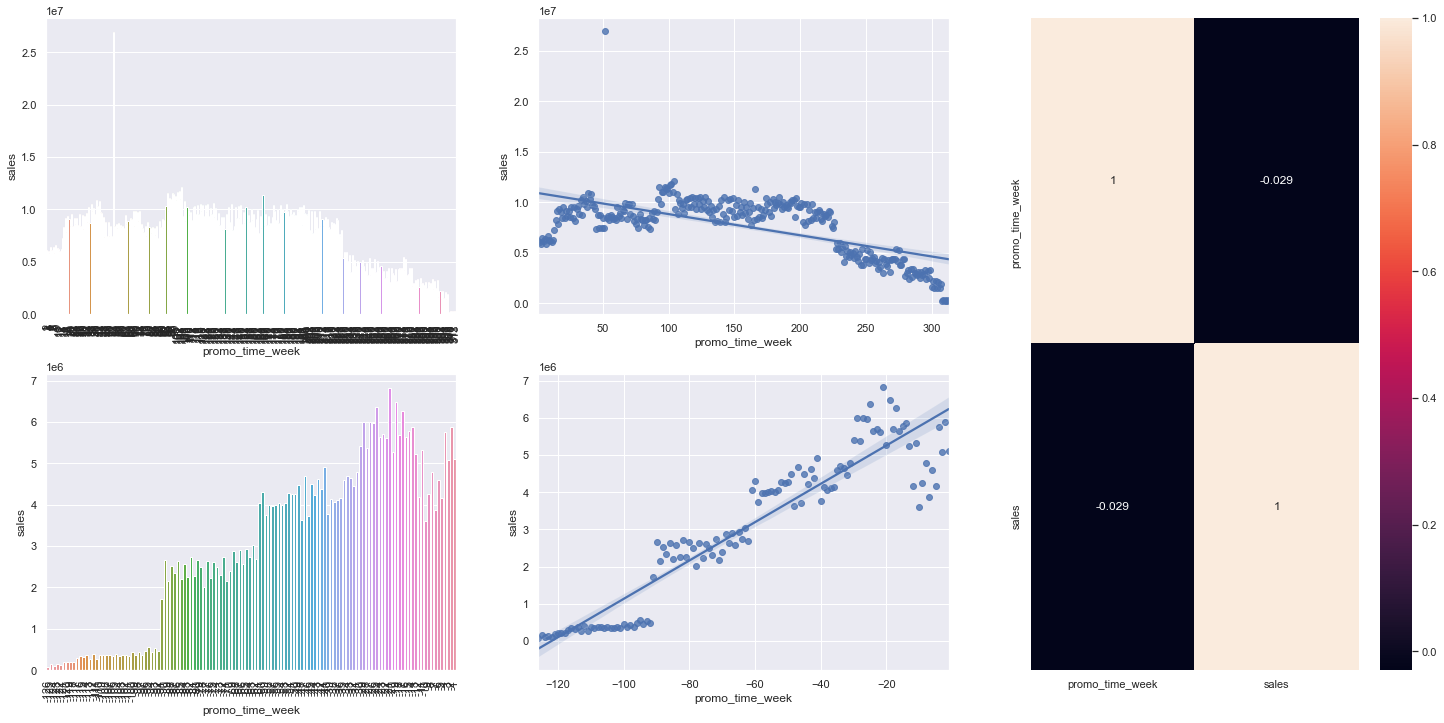

In [41]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### <s>h5 Stores with more promotion days should sell more.</s>

### h6 Stores with more consecutive promotions should sell more.
**False Hypothesis** = Stores with more consecutive promotions sell less.

In [42]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


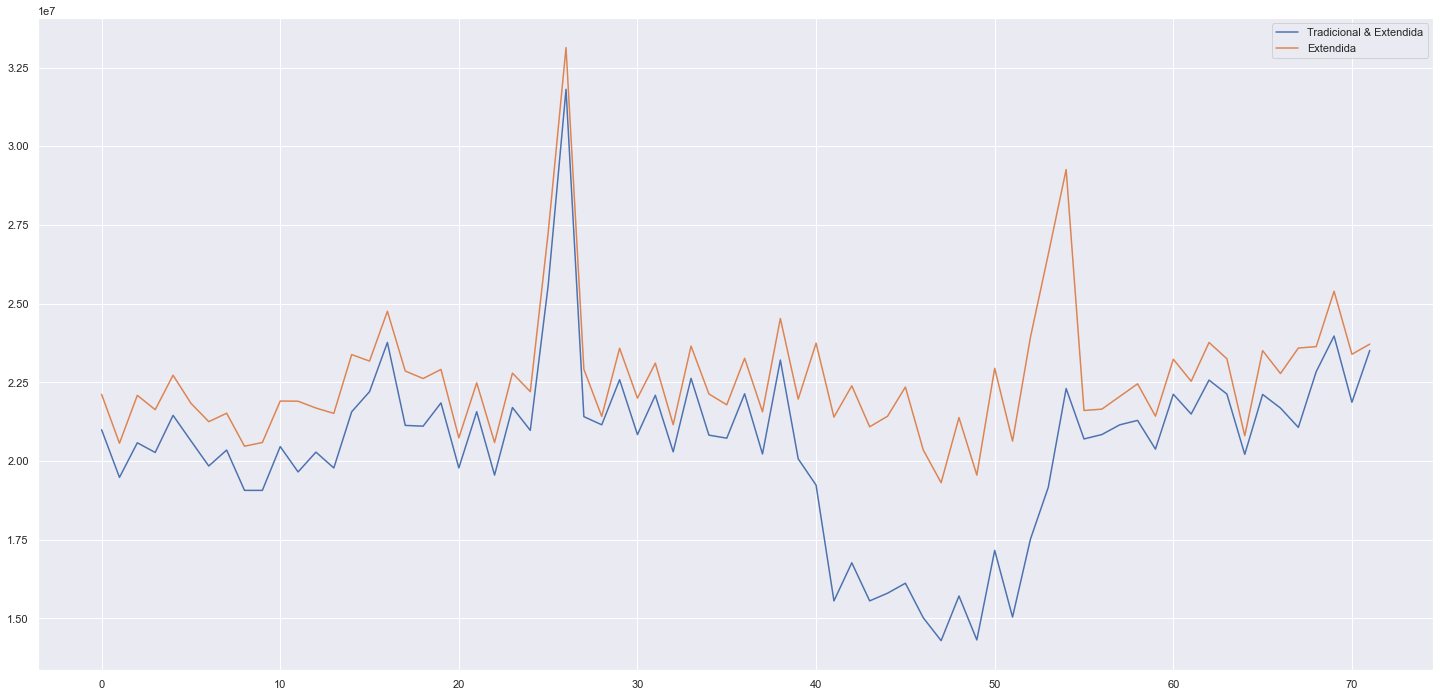

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels =['Tradicional & Extendida', 'Extendida']);

### H7 Stores open during the Christmas holiday should sell more.
**False Hypothesis** = The holiday that is less sold and at Christmas than Easter holiday and Public holidays.

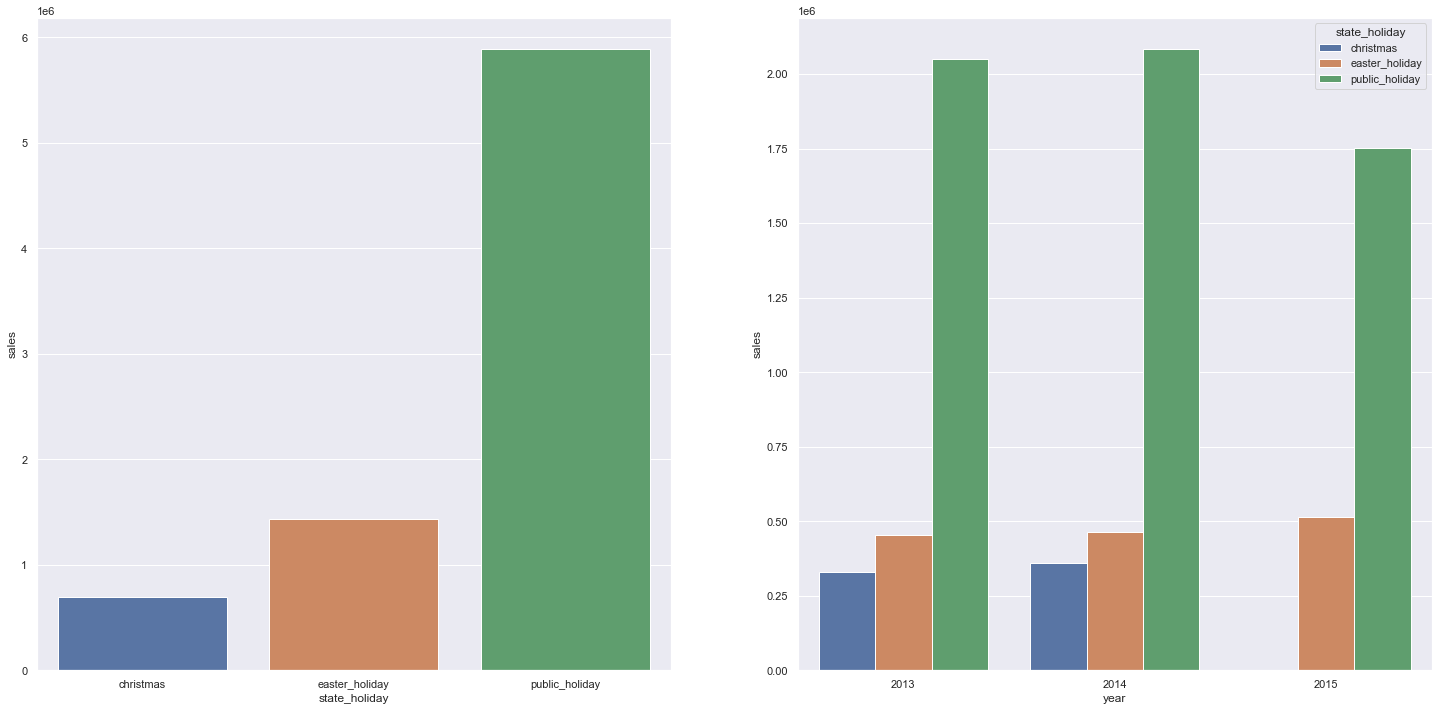

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day'] 

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt .subplot(1, 2, 2)
aux2 =aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x= "year", y='sales', hue='state_holiday', data= aux2 );

### H8 Stores should sell more over the years.
**False Hypothesis** = Stores no longer sell over the years.

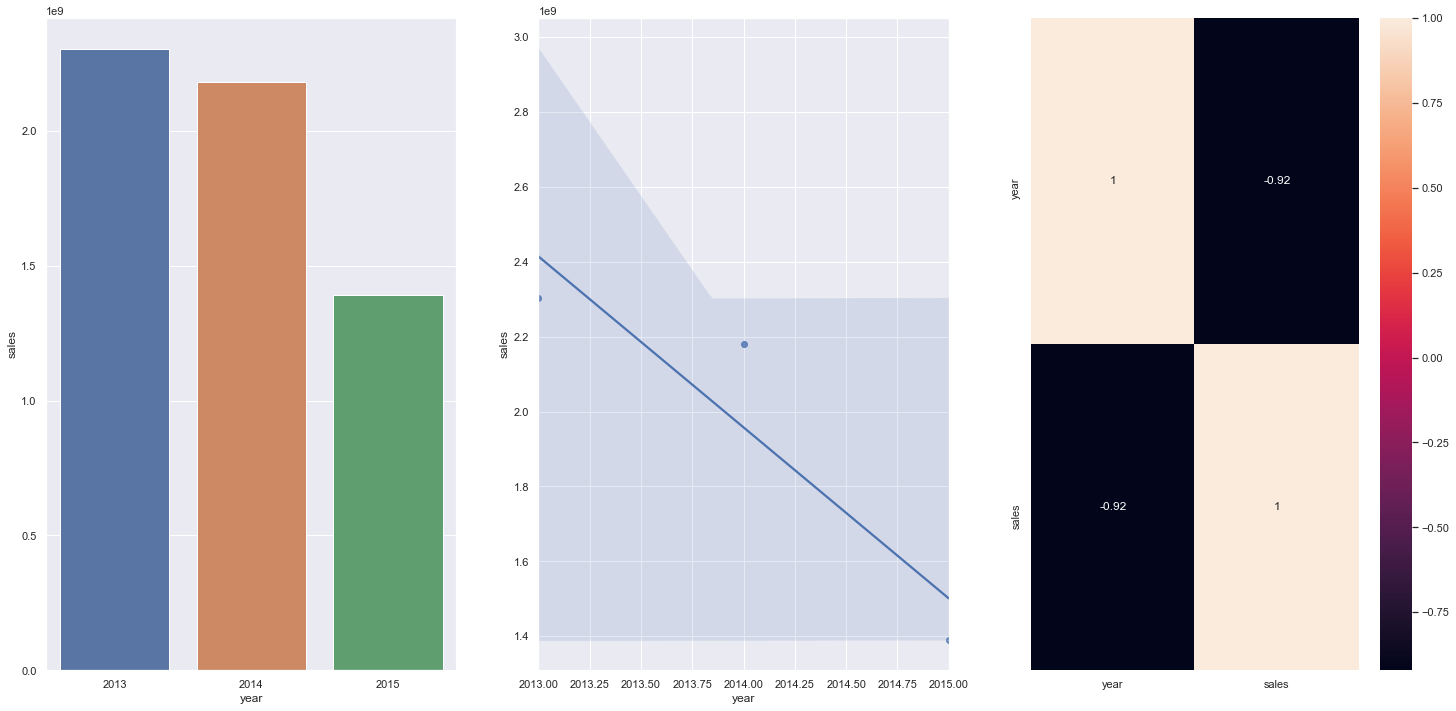

In [45]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 Stores were expected to sell more in the second half of the year.
**False Hypothesis** = Stores sell less in the second half of the year.


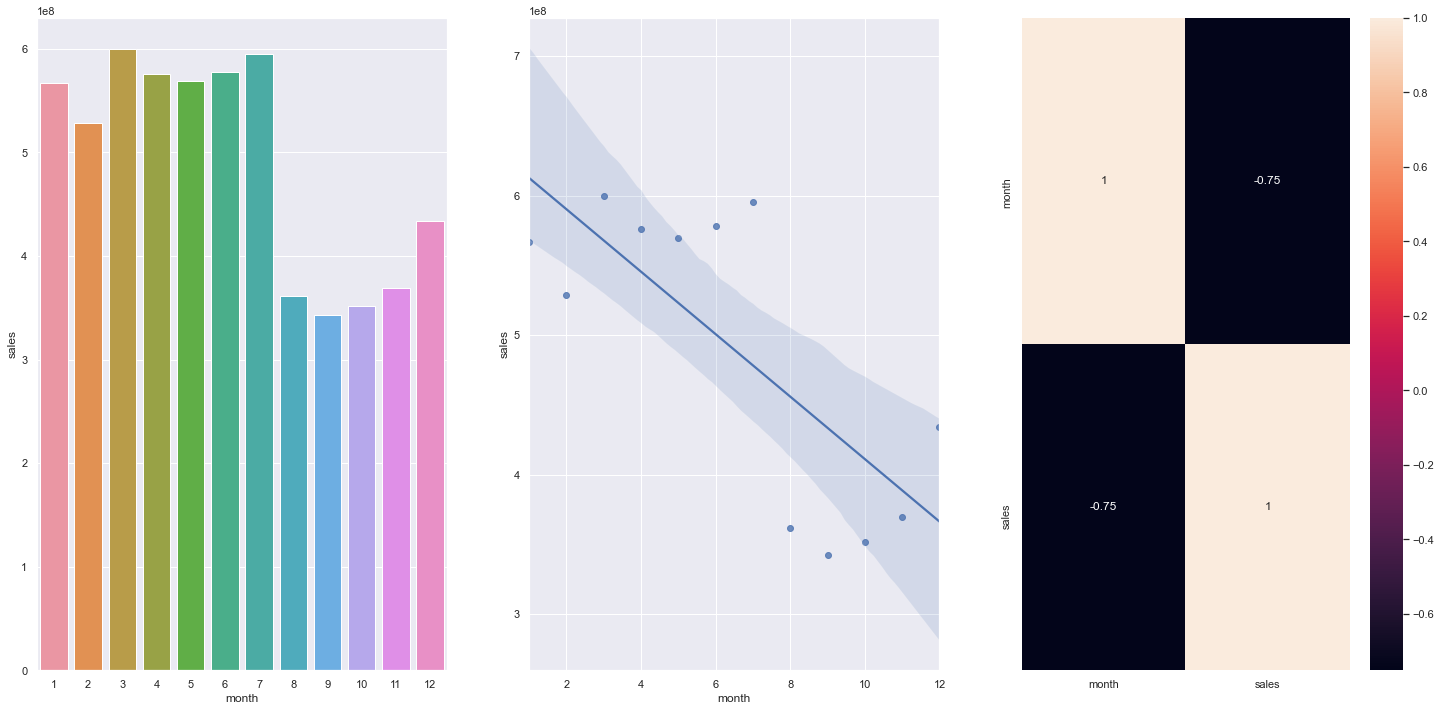

In [46]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H10 Stores should sell more after the 10th of each month.
**True Hypothesis**  = Stores actually sell more after the 10th of each month.


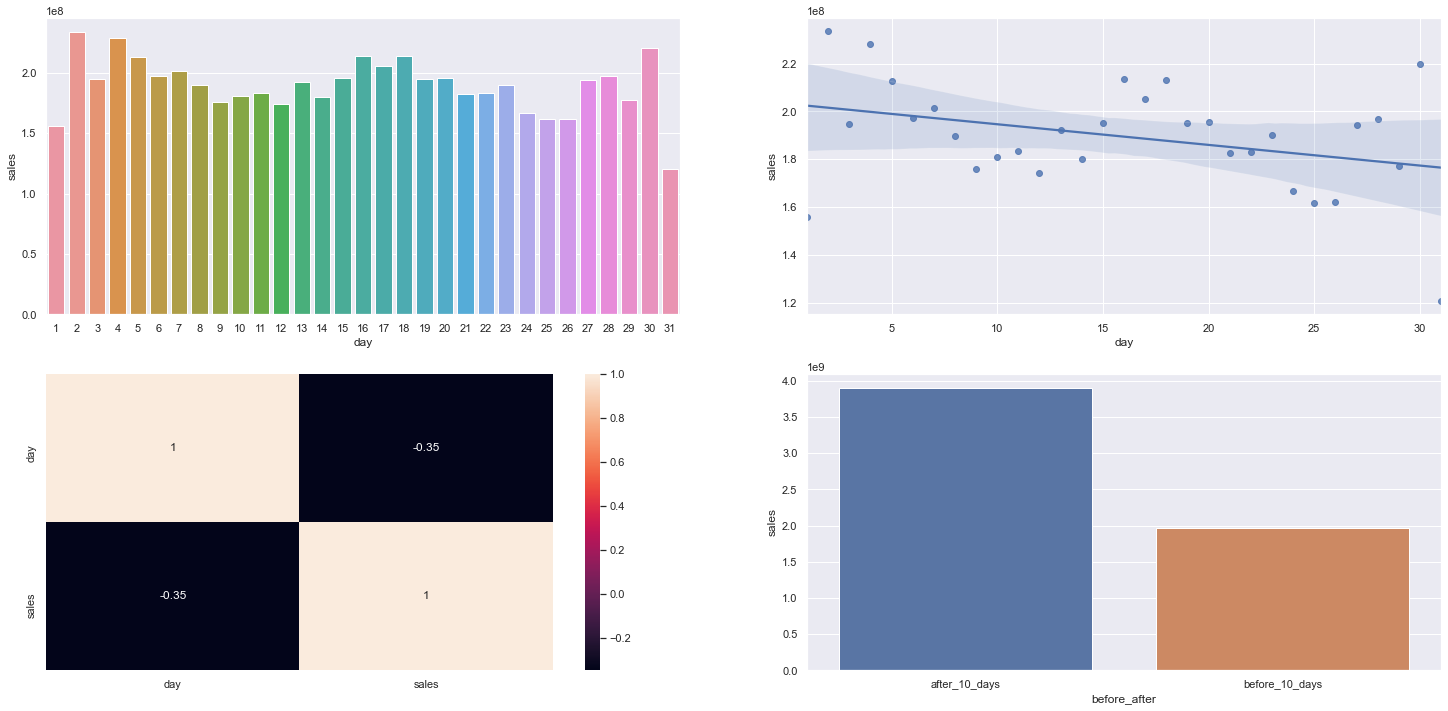

In [47]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11 Stores should sell less on weekends.
**True Hypothesis**  = Stores sell less on weekends. 

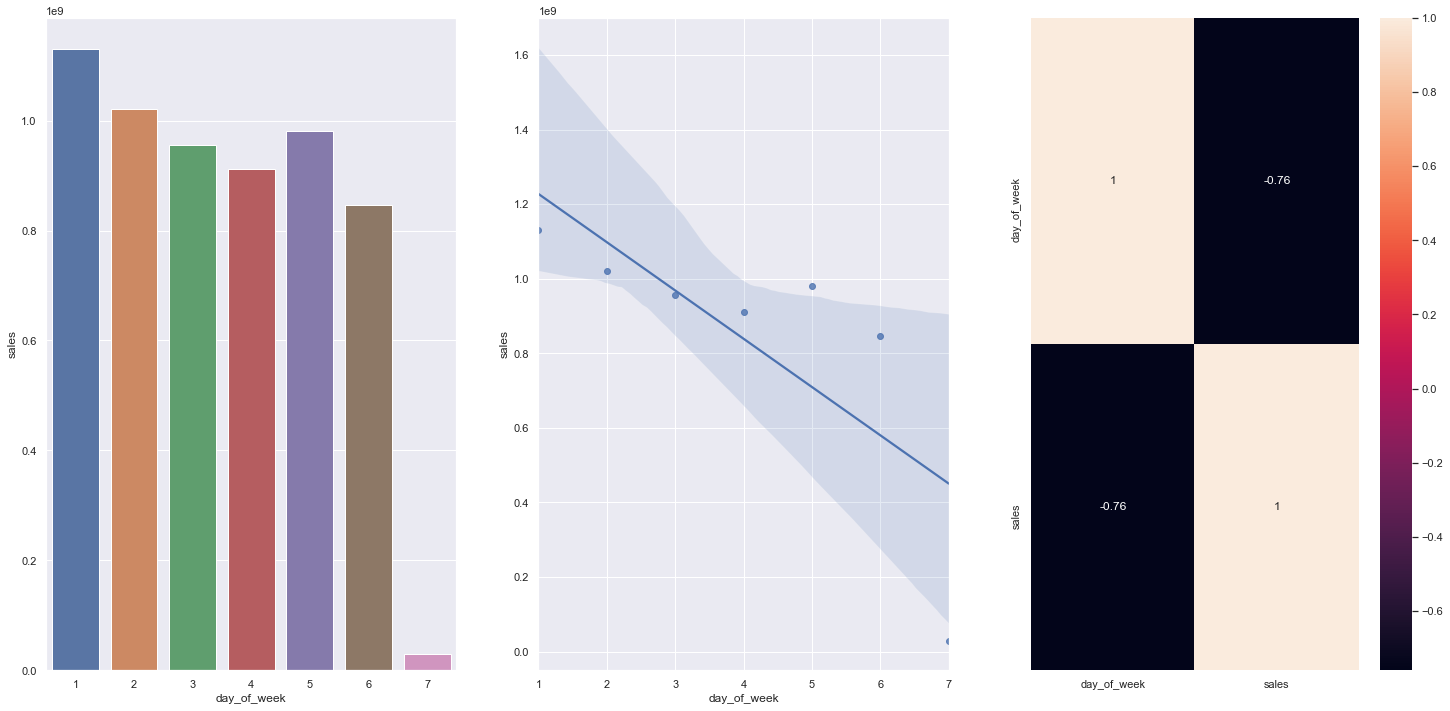

In [48]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 Stores sell sell less during school holidays.
**True Hypothesis**  = Store sell less in school holidays than regular days, except on july and august.

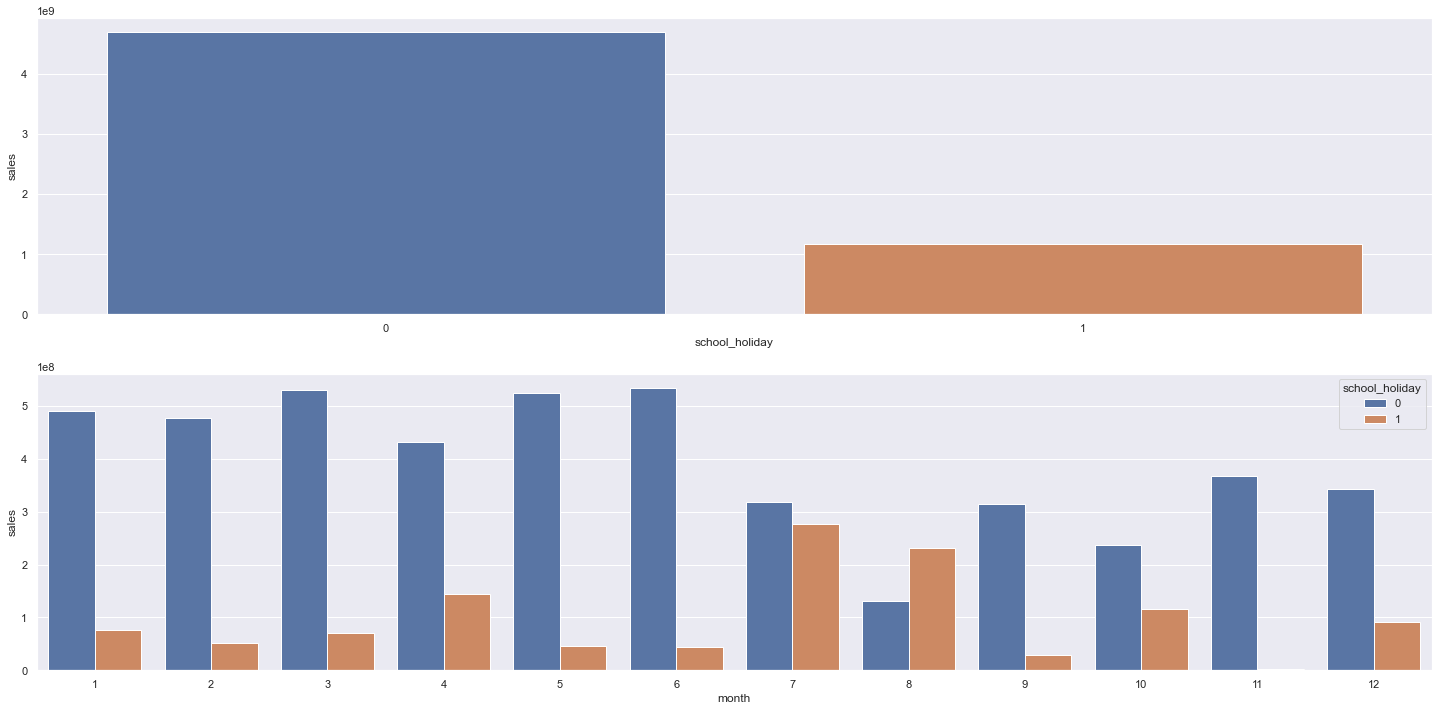

In [49]:
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipoteses

In [50]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
        ['H1', 'False', 'Low'],
        ['H2', 'False', 'Medium'],
        ['H3', 'False', 'Medium'],
        ['H4', 'False', 'Low'],
        ['H5', '-', '-'],
        ['H6', 'False', 'Low'],
        ['H7', 'False', 'Medium'],
        ['H8', 'False', 'High'],
        ['H9', 'False', 'High'],
        ['H10', 'True', 'High'],
        ['H11', 'True', 'High'],
        ['H12', 'False', 'Low'],
       ]

print(tabulate(tab, headers='firstrow')) 

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           False         Low


 ### 4.3 Multivariate analysis

 #### 4.3.1 Numerical Attributes

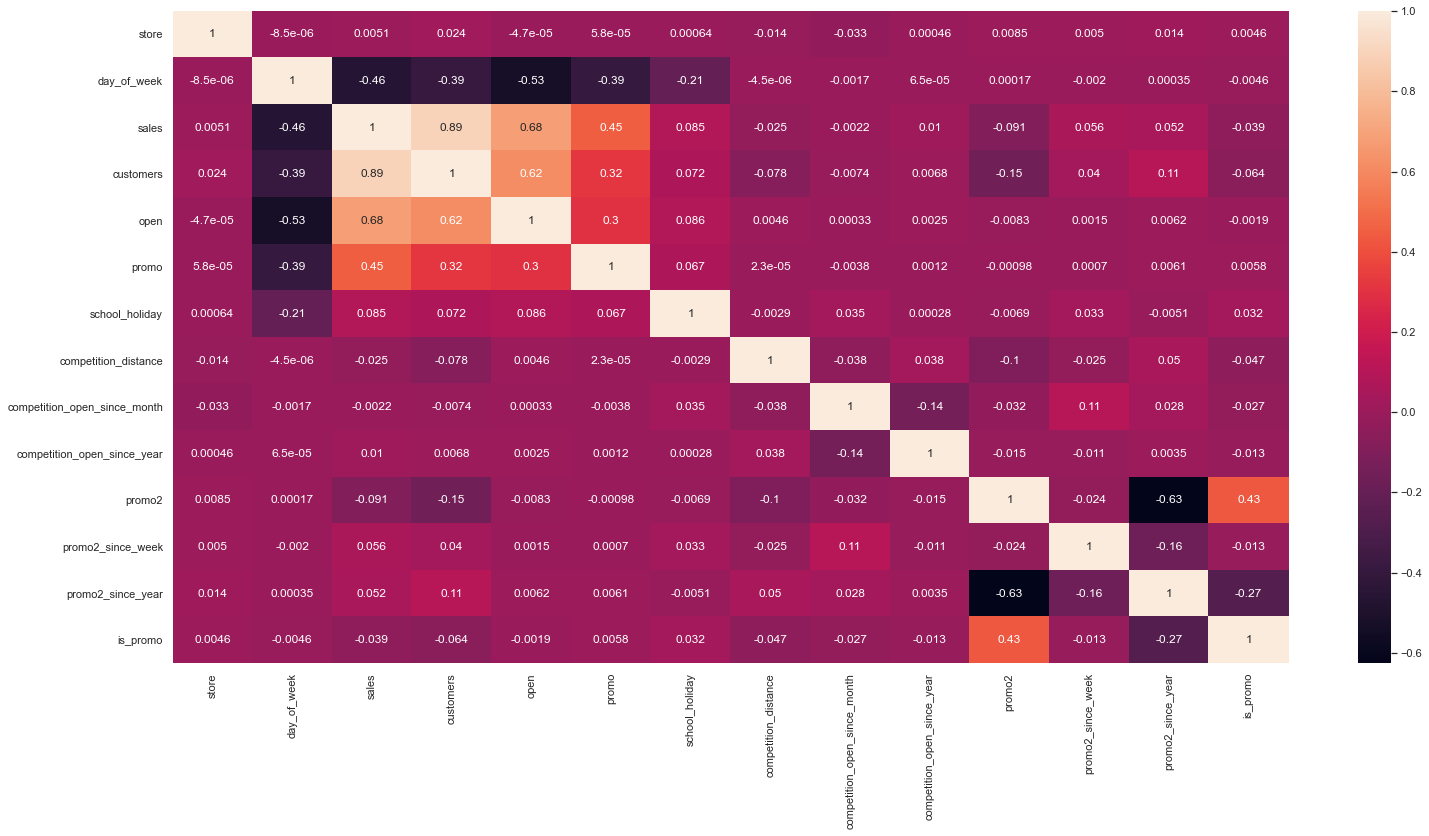

In [51]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

 #### 4.3.2 Categorical Attributes

In [52]:
from scipy import stats as ss

In [53]:
cramer_v(a['state_holiday'], a['store_type'])

0.23835291274582335

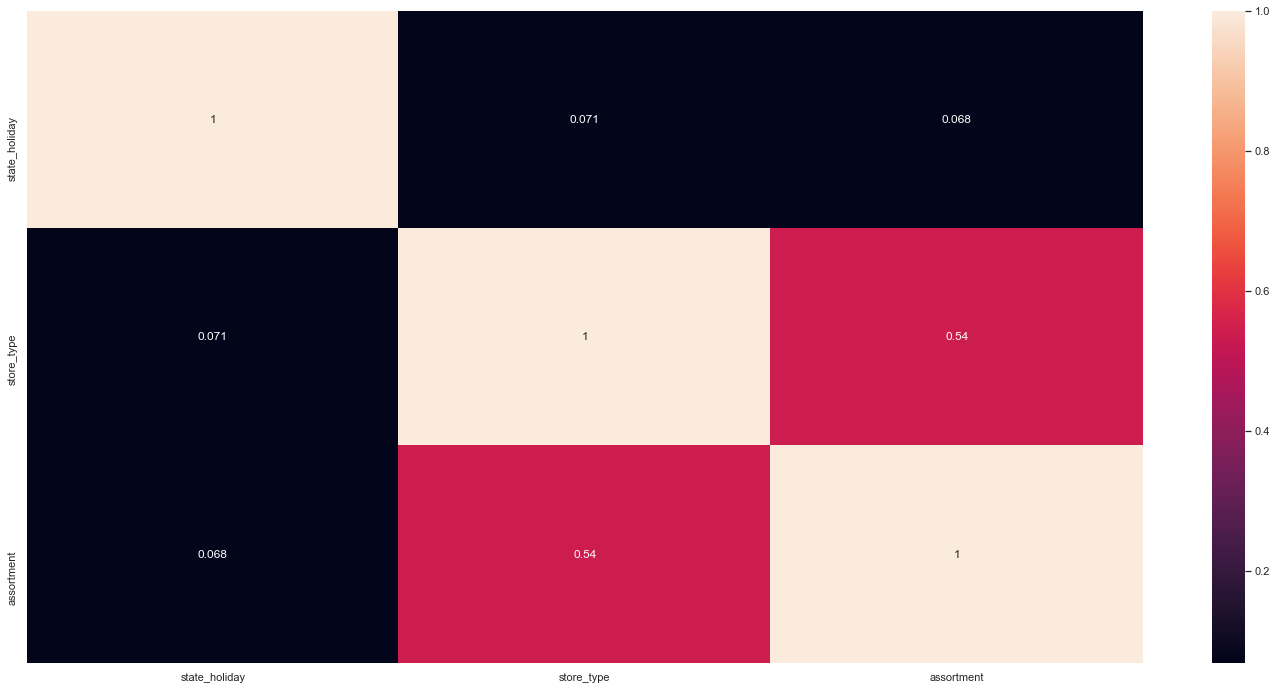

In [54]:
#only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d= pd.DataFrame({'state_holiday': [a1, a2,a3],
                  'store_type'  : [a4, a5,a6],
                  'assortment'  : [a7, a8,a9] })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

## 5.0 DATA PREPARATON

In [55]:
df5 = df4.copy()

### 5.1 Normalização

In [56]:
rs = RobustScaler() 
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) 

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] =  mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] =  mms.fit_transform(df5[['year']].values)

### 5.2 Encoding

In [57]:
# state_holiday - One hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label encoding
le = LabelEncoder()
df5['store_type'] =le.fit_transform(df5['store_type'])

# asssortment - Ordinal encoding
assortment_dict= {'basic':1,'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3 Transformation 

#### 5.2.1 Response Variable Transformation 

In [58]:
df5["sales"] = np.log1p(df5['sales'])

#### 5.2.2 Nature Transformation 

In [59]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x* ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x* ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x* ( 2. *np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x* ( 2. *np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x* ( 2. *np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x* ( 2. *np.pi/30 ) ) )


# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x* ( 2. *np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x* ( 2. *np.pi/52 ) ) )

## 6.0 FEATURE SELECTION

In [60]:
df6 = df5.copy()

In [61]:
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since','competition_since','year_week','promo_interval','month_map','customers']
df6 = df6.drop( cols_drop, axis=1 )

In [62]:
# start date of the last 6 weeks
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [63]:
# training dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# test dataset
X_test = df6[ df6['date'] > '2015-06-19' ]
y_test= X_test['sales']

print('Training min Date {}'.format(X_train['date'].min() ) )
print('Training max Date {}'.format(X_train['date'].max() ) )

print('\nTest min Date {}'.format(X_train['date'].min() ) )
print('Test max Date {}'.format(X_train['date'].max() ) )

Training min Date 2013-01-01 00:00:00
Training max Date 2015-06-18 00:00:00

Test min Date 2013-01-01 00:00:00
Test max Date 2015-06-18 00:00:00


### 6.2 Boruta as Feature Selector

In [64]:
'''# training and test dataset for Boruta
X_train_n = X_train.drop( ['date','sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define boruta
boruta =BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)'''

"# training and test dataset for Boruta\nX_train_n = X_train.drop( ['date','sales'], axis=1 ).values\ny_train_n = y_train.values.ravel()\n\n# define RandomForestRegressor\nrf = RandomForestRegressor( n_jobs=-1 )\n\n# define boruta\nboruta =BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)"

### 6.2.1 Best Features from Boruta

In [65]:
'''cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date','sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not_selected_boruta 
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )'''

"cols_selected = boruta.support_.tolist()\n\n# best features\nX_train_fs = X_train.drop( ['date','sales'], axis=1 )\ncols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()\n\n# not_selected_boruta \ncols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )"

In [66]:
#cols_selected_boruta

In [67]:
#cols_not_selected_boruta

### 6.3 Manual Feature Selection

In [68]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_cos',
     'month_sin',
     'day_cos',
     'day_sin',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend(feat_to_add)

In [69]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_sin',
 'week_of_year_cos']

## 7.0  MACHINE LEARNING MODELLING

In [70]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Times Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

### 7.1 Average Model

In [71]:
aux1= x_test.copy()
aux1['sales'] = y_test.copy()

# predition

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns ={'sales': 'preditions'} )
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['preditions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.452087,1854.263316


### 7.2 Linear Regression Model

In [72]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('linear Regression', np.expm1( y_test), np.expm1( yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,linear Regression,1868.73952,0.293745,2675.947846


### 7.2.1 Linear Regression Model - Cross Validation

In [73]:
model = LinearRegression().fit( x_train, y_train )
lr_result_cv = cross_validation( x_training, 5, ' LinearRegression CV ',lr, verbose=False )

In [74]:
lr_result_cv

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,LinearRegression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3 Linear Regression regularized Model - Lasso


In [75]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Lasso', np.expm1( y_test), np.expm1( yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1894.132075,0.290168,2750.818672


### 7.3.1 Linear Regression regularized Model - Lasso - Cross Validation

In [76]:
lrr_result_cv = cross_validation( x_training, 5, ' Lasso CV ',lrr, verbose=False )

In [77]:
lrr_result_cv

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,Lasso CV,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.4 Randon Forest Regressor

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf= rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test), np.expm1( yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.131152,0.100244,1013.734029


### 7.4.1 Randon Forest Regressor - Cross Validation

In [80]:
rf_result_cv = cross_validation( x_training, 5, ' Random Forest Regressor CV ',rf, verbose=False )

In [81]:
rf_result_cv

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,Random Forest Regressor CV,838.34 +/- 219.2,0.12 +/- 0.02,1258.05 +/- 320.2


### 7.5 XGBosst Regressor

In [82]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )

# prediction
yhat_xgb= model_xgb.predict(x_test)

#performance
xgb_result = ml_error('xgb Regressor', np.expm1( y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,xgb Regressor,6667.476609,0.949367,7320.384334


### 7.5.1 XGBosst Regressor - Cross Validation

In [83]:
result_xgb = cross_validation( x_training, 5, ' XGBosst Regressor ', model_xgb, verbose=False )

In [84]:
result_xgb

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,XGBosst Regressor,7049.16 +/- 588.42,0.95 +/- 0.0,7715.16 +/- 689.27


### 7.5 Compare Model's Performance

In [85]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.131152,0.100244,1013.734029
0,Average Model,1366.128351,0.452087,1854.263316
0,linear Regression,1868.739520,0.293745,2675.947846
0,Lasso,1894.132075,0.290168,2750.818672
0,xgb Regressor,6667.476609,0.949367,7320.384334


### 7.6 Real Performance - Cross Validation

In [86]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, result_xgb] )
modelling_result_cv

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,LinearRegression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso CV,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor CV,838.34 +/- 219.2,0.12 +/- 0.02,1258.05 +/- 320.2
0,XGBosst Regressor,7049.16 +/- 588.42,0.95 +/- 0.0,7715.16 +/- 689.27


**This project I chose work with XGBoost same it didn't best performance. However,  I will develop my abilities in using this algorithm.**

## 8.0 Hyperparameter Fine Tuning

**The use of hyperparameter is very important to improve the performance of the model.**

**The strategies to optimize the hyperparameter** consist of selecting the best combination of parameters for the model, avoiding that you have to do it manually by trial and error.

Although there are many optimization/adjustment algorithms for hyperparameters such as **Grid Search and Bayesian Search**, I chose to follow the **Random Search** strategy because despite setting the values randomly, it has quick execution and low cost compared to **Grid Search and Bayesian Search.**

Below are some of the advantages and disadvantages of the hyperparameter optimization strategies mentioned above.

1. **Random Search**
- Advantages: Fast and Low cost.
- Disadvantages: Defines the values at random.

2. **Grid Search**
- Advantages: Defines the true values that maximize the learning of the model.
- Disadvantages: Very long and costly execution.

3. **Bayesian Search**
- Advantages: Defines the values for hyperparameters based on past learning, it is faster than Grid Search.
- Disadvantages: Very long and costly execution.



### 8.1 Random Search

In [133]:
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7 ],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
           }

MAX_EVAL = 10

In [134]:
'''final_result =pd.DataFrame()

for i in range( MAX_EVAL ):
    #Choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
   #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] ) 

    
    #performance
    result = cross_validation( x_training, 5, "XGBoost Regressor", model_xgb, verbose=False )
    final_result = pd.concat( [final_result, result] )
    
final_result '''

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 's

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,XGBoost Regressor,1554.21 +/- 54.57,0.21 +/- 0.0,2262.83 +/- 99.67
0,XGBoost Regressor,1554.82 +/- 54.34,0.21 +/- 0.0,2263.2 +/- 98.13
0,XGBoost Regressor,1349.94 +/- 57.09,0.18 +/- 0.0,1967.0 +/- 99.9
0,XGBoost Regressor,1360.96 +/- 57.76,0.18 +/- 0.0,1988.47 +/- 104.72
0,XGBoost Regressor,819.82 +/- 88.71,0.11 +/- 0.01,1191.1 +/- 164.62
0,XGBoost Regressor,1283.87 +/- 50.81,0.17 +/- 0.0,1877.45 +/- 93.81
0,XGBoost Regressor,833.08 +/- 88.24,0.11 +/- 0.01,1217.25 +/- 160.27
0,XGBoost Regressor,922.73 +/- 76.86,0.13 +/- 0.01,1325.39 +/- 135.9
0,XGBoost Regressor,995.18 +/- 64.51,0.13 +/- 0.0,1460.5 +/- 128.07
0,XGBoost Regressor,966.31 +/- 75.26,0.13 +/- 0.01,1391.92 +/- 131.73


##### Parameters selected by Random Search:

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}

In [ ]:
# Performance of the model with the parameters selected above.
final_result =pd.DataFrame(final_result)
final_result

### 8.2 Final model

In [143]:
# parameters with the best performance
param_tuned = {
         'n_estimators':3500,
         'eta': 0.03,
         'max_depth':9 ,
         'subsample': 0.5,
         'colsample_bytree':0.9 ,
         'min_child_weight': 8 
           }



In [144]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=param_tuned['n_estimators'],
                                  eta=param_tuned['eta'],
                                  max_depth=param_tuned['max_depth'],
                                  subsample=param_tuned['subsample'],
                                  colsample_bytree=param_tuned['colsample_bytree'],
                                  min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train) 

# prediction 
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,622.953481,0.090005,913.225663
